In [1]:
# setting device on GPU if available, else CPU
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')


Using device: cuda

NVIDIA GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import torch
import numpy as np
import os
import torch.nn as nn
from tqdm import tqdm
import json
from functools import partial
from torch import einsum, nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from einops import pack, rearrange, reduce, repeat, unpack


In [4]:
def findAllFile(base):
    file_path = []
    for root, ds, fs in os.walk(base, followlinks=True):
        for f in fs:
            fullname = os.path.join(root, f)
            file_path.append(fullname)
    return file_path



In [5]:
# from utils.motion_processing.hml_process import recover_from_ric, recover_root_rot_pos,recover_from_rot
import utils.vis_utils.plot_3d_global as plot_3d
import matplotlib.pyplot as plt

def vis(mot , dset , name = "motion"):

    if isinstance(mot , torch.Tensor):
        mot = dset.toMotion(mot)
    mot =dset.inv_transform(mot)



    xyz = np.array(dset.to_xyz(mot).cpu())

    print(xyz.shape)

    
    plot_3d.render(xyz , f"/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/render/{name}.gif")

## VQVAE

In [110]:
from core.models.resnetVQ.vqvae import HumanVQVAE
from core.models.resnetVQ.vqvae import HumanVQVAE2

from configs.config import cfg, get_cfg_defaults


In [111]:
def load_vqvae(gen_cfg):
    
    body_cfg = get_cfg_defaults()
    body_cfg.merge_from_file(gen_cfg.vqvae.body_config)
    left_cfg = get_cfg_defaults()
    left_cfg.merge_from_file(gen_cfg.vqvae.left_hand_config)
    right_cfg = get_cfg_defaults()
    right_cfg.merge_from_file(gen_cfg.vqvae.right_hand_config)
    # left_hand_model = HumanVQVAE(left_cfg.vqvae).to("cuda").eval()
    # left_hand_model.load(os.path.join(left_cfg.output_dir, "vqvae_motion.pt"))
    
    # right_hand_model = HumanVQVAE(right_cfg.vqvae).to("cuda").eval()
    # right_hand_model.load(os.path.join(right_cfg.output_dir, "vqvae_motion.pt"))
    
    body_model = HumanVQVAE(body_cfg.vqvae).to("cuda").eval()
    body_model.load(os.path.join(body_cfg.output_dir, "vqvae_motion.pt"))

    return body_model, body_cfg
    


In [112]:
def load_vqvae2(gen_cfg):
    
    body_cfg = get_cfg_defaults()
    body_cfg.merge_from_file(gen_cfg.vqvae.body_config)
    left_cfg = get_cfg_defaults()
    left_cfg.merge_from_file(gen_cfg.vqvae.left_hand_config)
    right_cfg = get_cfg_defaults()
    right_cfg.merge_from_file(gen_cfg.vqvae.right_hand_config)
    # left_hand_model = HumanVQVAE(left_cfg.vqvae).to("cuda").eval()
    # left_hand_model.load(os.path.join(left_cfg.output_dir, "vqvae_motion.pt"))
    
    # right_hand_model = HumanVQVAE(right_cfg.vqvae).to("cuda").eval()
    # right_hand_model.load(os.path.join(right_cfg.output_dir, "vqvae_motion.pt"))
    
    body_model = HumanVQVAE2(body_cfg.vqvae).to("cuda").eval()
    body_model.load(os.path.join(body_cfg.output_dir, "vqvae_motion.pt"))

    return body_model, body_cfg
    


In [113]:


def bkn_to_motion(codes, dset):
        # codes b k n
        body_inds = codes[:, 0]
    
        body_motion = body_model.decode(body_inds[0:1]).detach().cpu()

        if "g" in dset.hml_rep:
            z = torch.zeros(
                body_motion.shape[:-1] + (2,),
                dtype=body_motion.dtype,
                device=body_motion.device,
            )
            body_motion = torch.cat(
                [body_motion[..., 0:1], z, body_motion[..., 1:]], -1
            )
        
        body_M = dset.toMotion(
            body_motion[0],
            motion_rep=MotionRep(body_cfg.dataset.motion_rep),
            hml_rep=body_cfg.dataset.hml_rep,
        )
        

        return body_M



## Motion Gen

In [ ]:
from core import MotionRep, AudioRep, TextRep
from core.datasets.conditioner import ConditionProvider, ConditionFuser
from core.datasets.multimodal_dataset import MotionIndicesAudioTextDataset, load_dataset_gen, simple_collate
from core.models.generation.motion_generator import Transformer, MotionMuse
from core.models.utils import instantiate_from_config, get_obj_from_str


In [ ]:
from configs.config_t2m import cfg, get_cfg_defaults
from configs.config import get_cfg_defaults as get_cfg_defaults3

cfg = get_cfg_defaults()
cfg.merge_from_file("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/motion_generation/motion_generation.yaml")
cfg.freeze()
mmuse_args = cfg.motion_generator
dataset_args = cfg.dataset


In [ ]:
target = mmuse_args.pop("target")
motion_muse = MotionMuse(mmuse_args).to(device).eval()

In [ ]:
from core.models.resnetVQ.vqvae import HumanVQVAE

In [ ]:

vcfg = get_cfg_defaults3()
vcfg.merge_from_file("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/vqvae/vqvae_body_gprvc/vqvae_body_gprvc.yaml")
vqvae_args = vcfg.vqvae
vqvae_args.nb_joints = 22
vqvae_args.motion_dim = 263

In [ ]:
np.split(np.cusum)

In [ ]:
vqvae_model = HumanVQVAE(vqvae_args).to(device).eval()
vqvae_model.load("/srv/hays-lab/scratch/sanisetty3/music_motion/ACMG/checkpoints/smplx_resnet/vqvae_motion.pt")

In [ ]:
condition_provider = ConditionProvider(
            motion_rep=MotionRep(dataset_args.motion_rep),
            audio_rep=AudioRep(dataset_args.audio_rep),
            text_rep=TextRep(dataset_args.text_rep),
            motion_padding=dataset_args.motion_padding,
            audio_padding=dataset_args.audio_padding,
            motion_max_length_s=10,
            audio_max_length_s=10,
            pad_id = motion_muse.transformer.pad_token_id,
            fps=30/4
        )

In [ ]:
# bod_ind = np.load("/srv/hays-lab/scratch/sanisetty3/motionx/indices/body/aist/subset_0000/Dance_Break_3_Step_clip_1.npy")
# lh_ind = np.load("/srv/hays-lab/scratch/sanisetty3/motionx/indices/left_hand/aist/subset_0000/Dance_Break_3_Step_clip_1.npy")
# rh_ind = np.load("/srv/hays-lab/scratch/sanisetty3/motionx/indices/right_hand/aist/subset_0000/Dance_Break_3_Step_clip_1.npy")

In [ ]:
from core.datasets.multimodal_dataset import MotionIndicesAudioTextDataset, load_dataset_gen, simple_collate

dset = MotionIndicesAudioTextDataset("animation" , "/srv/hays-lab/scratch/sanisetty3/motionx" ,motion_rep = "full", split = "train" , fps = 30/4  )

In [ ]:
inpss  = next(iter(dset))

In [ ]:
train_ds, sampler_train, weights_train  = load_dataset_gen(dataset_args=dataset_args, split = "train" , dataset_names = ["animation" , "choreomaster" ] )

In [ ]:
train_loader = torch.utils.data.DataLoader(
        dset,
        4,
        # sampler=sampler_train,
        # shuffle = False,
        collate_fn=partial(simple_collate , conditioner = condition_provider),
        drop_last=True,
    )

In [ ]:
for inputs, conditions in train_loader:
    break
    

In [ ]:
inputs["motion"][0].shape

In [ ]:
inputs["motion"][1].shape

In [ ]:
conditions["audio"][0].shape

In [ ]:
conditions["text"][0].shape

In [ ]:
motions = inputs["motion"][0].squeeze().to(torch.long)
motion_mask = inputs["motion"][1]

In [ ]:
fuse_method = {"cross": ["audio"], "prepend": ["text"]}
condition_fuser = ConditionFuser(fuse_method)

In [ ]:
audio_embed = self.project_audio(conditions["audio"][0])
text_embed = self.project_text(conditions["text"][0])

inputs_, cross_inputs = self.condition_fuser(
    input,
    {
        "text": (text_embed, conditions["text"][1]),
        "audio": (audio_embed, conditions["audio"][1]),
    },
)

## Muse gen

In [6]:
from core import MotionTokenizerParams, pattern_providers

from core.param_dataclasses import pattern_providers
from core.datasets.multimodal_dataset import MotionIndicesAudioTextDataset, load_dataset_gen, simple_collate
from core.models.utils import instantiate_from_config, get_obj_from_str
from core import MotionRep, AudioRep, TextRep
from core.datasets.conditioner import ConditionProvider,ConditionFuser
from core.models.generation.muse import MLMModel, MotionMuse
import einops
from configs.config_t2m import get_cfg_defaults as muse_get_cfg_defaults

from core.datasets.text_encoders import BERTConditioner, ClipConditioner, T5Conditioner, parse_prompt_attention
from core.datasets.audio_encoders import EncodecConditioner, LibrosaConditioner

/srv/hays-lab/flash5/sanisetty3/miniconda3/envs/tgm3d/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# ds, _, _  = load_dataset_gen(dataset_names = ["animation"] , dataset_args=dataset_args, split = "render")


In [9]:
motion_gen = MotionMuse(tranformer_config , fuse_config , pattern_config).to(device)
# pkg = torch.load("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/motion_muse/motion_muse.pt", map_location="cuda")
# motion_gen.load_state_dict(pkg["model"])

NameError: name 'tranformer_config' is not defined

In [ ]:
_, conditions = condition_provider(raw_audio= None, raw_text="a person doing kung fu kick and then jumping")
_, neg_conditions = condition_provider(raw_text="")
gen_ids = motion_gen.generate(conditions =conditions, neg_conditions = None, duration_s = 30, temperature = 0.2 ,timesteps=18, cond_scale = 8)


## MotionMuse

In [6]:
from core import MotionTokenizerParams, pattern_providers

from core.param_dataclasses import pattern_providers
from core.datasets.multimodal_dataset import MotionIndicesAudioTextDataset, load_dataset_gen, simple_collate
from core.models.utils import instantiate_from_config, get_obj_from_str
from core import MotionRep, AudioRep, TextRep
from core.datasets.conditioner import ConditionProvider,ConditionFuser
from core.models.generation.muse import MLMModel, MotionMuse
import einops
from configs.config_t2m import get_cfg_defaults as muse_get_cfg_defaults
from core import MotionTokenizerParams

from core.datasets.text_encoders import BERTConditioner, ClipConditioner, T5Conditioner, parse_prompt_attention
from core.datasets.audio_encoders import EncodecConditioner, LibrosaConditioner

/srv/hays-lab/flash5/sanisetty3/miniconda3/envs/tgm3d/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
gen_cfg = muse_get_cfg_defaults()
gen_cfg.merge_from_file("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/motion_muse_constant/motion_muse_constant.yaml")
gen_cfg.freeze()

In [8]:
tranformer_config = gen_cfg.motion_generator
fuse_config = gen_cfg.fuser
pattern_config = gen_cfg.codebooks_pattern
dataset_args = gen_cfg.dataset

target = tranformer_config.pop("target")


In [9]:
motion_gen = MotionMuse(tranformer_config , fuse_config , pattern_config).to(device)
# motion_gen = torch.compile(motion_gen)
# pkg = torch.load("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/motion_muse_constant/checkpoints/motion_muse.70000.pt", map_location="cuda")
# motion_gen.load_state_dict(pkg["model"])

Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda


In [114]:
body_model, body_cfg = load_vqvae2(gen_cfg)

Sync is turned on False
loaded model with  0.03015906736254692 tensor([110000.], device='cuda:0') steps


In [10]:
condition_provider = ConditionProvider(
            text_conditioner_name = dataset_args.text_conditioner_name,
            motion_rep=MotionRep(dataset_args.motion_rep),
            audio_rep=AudioRep(dataset_args.audio_rep),
            text_rep=TextRep(dataset_args.text_rep),
            motion_padding=dataset_args.motion_padding,
            audio_padding=dataset_args.audio_padding,
            motion_max_length_s=dataset_args.motion_max_length_s,
            audio_max_length_s=dataset_args.audio_max_length_s,
            pad_id = MotionTokenizerParams(tranformer_config.num_tokens).pad_token_id,
            fps=30/4,
            # device = "cpu"
        )

/srv/hays-lab/flash5/sanisetty3/miniconda3/envs/tgm3d/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [97]:
# dset = MotionIndicesAudioTextDataset("animation" , "/srv/hays-lab/scratch/sanisetty3/motionx" ,hml_rep = "gpvc" , window_size_s=4, motion_rep = "body", split = "train" , fps = 30/4  )


In [98]:
# dset[0]["motion"].shape

In [11]:
train_ds, sampler_train, weights_train  = load_dataset_gen(dataset_names = ["animation" , "choreomaster"] , dataset_args=dataset_args, split = "train")


Total number of motions animation: 120 and texts 120
Total number of motions choreomaster: 34 and texts 34


In [12]:
train_loader = torch.utils.data.DataLoader(
        train_ds,
        4,
        sampler=sampler_train,
        # shuffle = False,
        collate_fn=partial(simple_collate , conditioner = condition_provider , permute = True),
        # drop_last=True,
    )

In [13]:
for inputs, conditions in (train_loader):
    break
    

In [14]:
inputs["names"]

array(['choreomaster/1040', 'choreomaster/1093',
       'animation/subset_0000/Ways_To_Enter_A_Room_Police',
       'choreomaster/0071'], dtype='<U49')

In [15]:
motion_gen.model.condition_fuser.cond2fuse

{'text': 'cross', 'audio': 'input_interpolate'}

In [16]:
conditions["audio"][0].shape

torch.Size([4, 120, 128])

In [17]:
conditions["text"][0].shape

torch.Size([4, 32, 1024])

In [18]:
inputs["motion"][0].shape

torch.Size([4, 1, 30])

In [19]:
loss , logits = motion_gen(inputs["motion"] , conditions, return_logits=True)

In [115]:
motions_ids = inputs["motion"][0].cuda()
B, K, T = motions_ids.shape

In [116]:
motions_ids.shape

torch.Size([4, 1, 30])

In [120]:
gen_motion = bkn_to_motion(motions_ids[0:1], train_ds.datasets[0])
train_ds.datasets[0].render_hml(
                    gen_motion,
                    "/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/render/gen_novel.gif"
                )

rpos torch.Size([120, 3])
torch.Size([120, 21, 3])


## Translation transformer

In [48]:
from core import MotionTokenizerParams, pattern_providers

from core.param_dataclasses import pattern_providers
from core.datasets.multimodal_dataset import MotionIndicesAudioTextDataset, load_dataset_gen, simple_collate
from core.models.utils import instantiate_from_config, get_obj_from_str
from core import MotionRep, AudioRep, TextRep
from core.datasets.conditioner import ConditionProvider,ConditionFuser
import einops
from configs.config_t2m import get_cfg_defaults as muse_get_cfg_defaults
from core import MotionTokenizerParams

from core.datasets.text_encoders import BERTConditioner, ClipConditioner, T5Conditioner, parse_prompt_attention
from core.datasets.audio_encoders import EncodecConditioner, LibrosaConditioner

In [10]:
gen_cfg = muse_get_cfg_defaults()
gen_cfg.merge_from_file("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/motion_translation/motion_translation.yaml")
gen_cfg.freeze()

tranformer_config = gen_cfg.translation_transformer
fuse_config = gen_cfg.fuser
dataset_args = gen_cfg.dataset

target = tranformer_config.pop("target")


In [12]:
condition_provider = ConditionProvider(
            text_conditioner_name = dataset_args.text_conditioner_name,
            motion_rep=MotionRep(dataset_args.motion_rep),
            audio_rep=AudioRep(dataset_args.audio_rep),
            text_rep=TextRep(dataset_args.text_rep),
            motion_padding=dataset_args.motion_padding,
            audio_padding=dataset_args.audio_padding,
            motion_max_length_s=dataset_args.motion_max_length_s,
            audio_max_length_s=dataset_args.audio_max_length_s,
            fps=30/4,
            # device = "cpu"
        )

/srv/hays-lab/flash5/sanisetty3/miniconda3/envs/tgm3d/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [ ]:
train_ds, sampler_train, weights_train  = load_dataset_gen(dataset_names = ["animation" , "choreomaster"] , dataset_args=dataset_args, split = "train")


In [ ]:
train_loader = torch.utils.data.DataLoader(
        train_ds,
        4,
        sampler=sampler_train,
        # shuffle = False,
        collate_fn=partial(simple_collate , conditioner = condition_provider , permute = True),
        # drop_last=True,
    )

In [ ]:
for inputs, conditions in (train_loader):
    break
    

In [82]:
pose = torch.Tensor(np.load("/srv/hays-lab/scratch/sanisetty3/motionx/motion_data/smplx_322/idea400/subset_0056/Walking_And_Snapping_At_The_Same_Time.npy"))

In [122]:
mot = np.load("/srv/hays-lab/scratch/sanisetty3/motionx/motion_data/new_joint_vecs/idea400/subset_0056/Walking_And_Snapping_At_The_Same_Time.npy")

In [124]:

def recover_root_rot_pos(data):
    rot_vel = data[..., 0]
    r_rot_ang = torch.zeros_like(rot_vel).to(data.device)
    """Get Y-axis rotation from rotation velocity"""
    r_rot_ang[..., 1:] = rot_vel[..., :-1]
    r_rot_ang = torch.cumsum(r_rot_ang, dim=-1)

    r_rot_quat = torch.zeros(data.shape[:-1] + (4,)).to(data.device)
    r_rot_quat[..., 0] = torch.cos(r_rot_ang)
    r_rot_quat[..., 2] = torch.sin(r_rot_ang)

    r_pos = torch.zeros(data.shape[:-1] + (3,)).to(data.device)
    data = data.to(torch.float)
    r_pos[..., 1:, [0, 2]] = data[..., :-1, 1:3]
    """Add Y-axis rotation to root position"""
    r_pos = qrot(qinv(r_rot_quat), r_pos)

    r_pos = torch.cumsum(r_pos, dim=-2)

    r_pos[..., 1] = data[..., 3]
    return r_rot_quat, r_pos

In [132]:
mot.shape

(239, 623)

In [133]:
59*4

236

In [135]:
# trans = pose[:, 309 : 309 + 3]
# root_pos_init = trans[0]
# root_pose_init_xz = root_pos_init * np.array([1, 0, 1])
# trans = trans - root_pose_init_xz
# root_orient=pose[:, :3]
# rq = geometry.axis_angle_to_quaternion(root_orient)

In [137]:
r_rot_quat.shape

torch.Size([236, 4])

In [68]:
from core.models.resnetVQ.encdec import Encoder, Decoder
from core.models.generation.translation_transformer import TranslationTransformer, TransformerBlock
from core.models.positional_embeddings import ScaledSinusoidalEmbedding
from core import (
    PositionalEmbeddingParams,
    
)

In [69]:
transformer = TransformerBlock(512 , depth=2)
pos_emb = ScaledSinusoidalEmbedding(
            PositionalEmbeddingParams(dim=512)
        )

In [73]:
enc = Encoder(2 , 512 , down_t = 2 , depth=1)
dec = Decoder(6 , 512 , down_t = 2, depth=1)

torch.Size([1, 2, 239])

In [141]:
r_rot_quat, r_pos = recover_root_rot_pos(torch.Tensor(mot)[:236])
traj1 = r_pos[None , :, [0,2]].permute(0,2,1)

In [142]:
x = enc(traj1)
x = x.permute(0,2,1)
x = x + pos_emb(x)
x = transformer(x = x, context = x)
x = x.permute(0,2,1)
x = dec(x)
x = x.permute(0,2,1)

In [143]:
x.shape

torch.Size([1, 236, 6])

## TODO:

Go from trans to root orient

In [56]:
motions = inputs["motion"][0].to(torch.long)
gt_motion = bkn_to_motion(motions[1:2], train_ds.datasets[0])
train_ds.datasets[0].render_hml(
                    gt_motion,
                    "/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/render/idea400_ztoe.gif",
    zero_trans=True,
    zero_orient=True,
    translation_external = trans_ext
    
                    
                )

In [50]:
pose = torch.Tensor(np.load("/srv/hays-lab/scratch/sanisetty3/motionx/motion_data/smplx_322/idea400/subset_0056/Walking_And_Snapping_At_The_Same_Time.npy"))
trans = pose[:, 309 : 309 + 3]
root_orient=pose[:, :3]
trans_ext = trans[:120,[0,2]]


In [54]:
trans_ext = torch.zeros((120 , 2))
trans_ext[:,0] = torch.linspace(0,5 , 120)

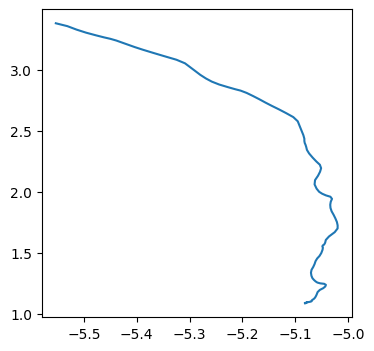

In [51]:
fig = plt.figure(figsize=(4,4))
plt.plot(trans_ext[:,0].numpy(), trans_ext[:,1].numpy())


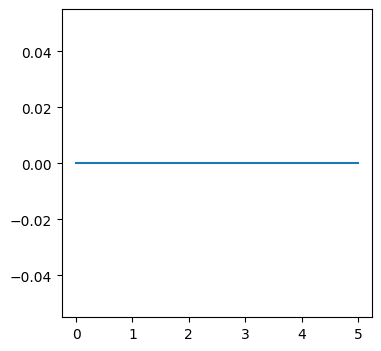

In [55]:
fig = plt.figure(figsize=(4,4))
plt.plot(trans_ext[:,0].numpy(), trans_ext[:,1].numpy())


In [31]:
import time
start = time.time()
for i in range(100):
    loss , logits = motion_gen(inputs["motion"] , conditions, return_logits=True)
end = time.time()
print('nn attention took {} seconds'.format(end - start))

nn attention took 1.8568298816680908 seconds


In [ ]:
input_mask = inputs["motion"][1]
motions_ids = inputs["motion"][0].cuda()
B, K, T = motions_ids.shape

In [ ]:
motions_ids.shape

In [109]:
gen_motion = bkn_to_motion(motions_ids, train_ds.datasets[0])

NameError: name 'bkn_to_motion' is not defined

In [ ]:
train_ds.datasets[0].render_hml(
                    gt_motion[1].detach().squeeze().cpu(),
                    "/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/render/gt_motion_recon.gif"
                )

In [82]:
raw_audio = "/srv/hays-lab/scratch/sanisetty3/motionx/audio/wav/beat/1_wayne_0_1_1.wav"
raw_audio2 = "/srv/hays-lab/scratch/sanisetty3/motionx/audio/wav/choreomaster/0071.wav"

In [83]:
_, conditions = condition_provider(raw_audio= raw_audio, raw_text="a person speaking")
_, neg_conditions = condition_provider(raw_text="")

In [84]:

gen_ids = motion_gen.generate(conditions = conditions, neg_conditions = None, duration_s = 4, temperature = 0.2 ,timesteps=18, cond_scale = 3)


100%|██████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 42.96it/s]


In [85]:
# _, conditions = condition_provider(raw_audio= raw_audio2)
gen_motion = bkn_to_motion(gen_ids, train_ds.datasets[0])
train_ds.datasets[0].render_hml(
                    gen_motion,
                    "/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/render/gen_novel.gif"
                )

In [13]:
from utils.motion_processing.quaternion import qinv, qrot, quaternion_to_cont6d
import utils.rotation_conversions as geometry

In [14]:
mot = np.load("/srv/hays-lab/scratch/sanisetty3/motionx/motion_data/new_joint_vecs/idea400/subset_0056/Walking_And_Snapping_At_The_Same_Time.npy")

In [15]:
pose = torch.Tensor(np.load("/srv/hays-lab/scratch/sanisetty3/motionx/motion_data/smplx_322/idea400/subset_0056/Walking_And_Snapping_At_The_Same_Time.npy"))

In [16]:

def recover_root_rot_pos(data):
    rot_vel = data[..., 0]
    r_rot_ang = torch.zeros_like(rot_vel).to(data.device)
    """Get Y-axis rotation from rotation velocity"""
    r_rot_ang[..., 1:] = rot_vel[..., :-1]
    r_rot_ang = torch.cumsum(r_rot_ang, dim=-1)

    r_rot_quat = torch.zeros(data.shape[:-1] + (4,)).to(data.device)
    r_rot_quat[..., 0] = torch.cos(r_rot_ang)
    r_rot_quat[..., 2] = torch.sin(r_rot_ang)

    r_pos = torch.zeros(data.shape[:-1] + (3,)).to(data.device)
    data = data.to(torch.float)
    r_pos[..., 1:, [0, 2]] = data[..., :-1, 1:3]
    """Add Y-axis rotation to root position"""
    r_pos = qrot(qinv(r_rot_quat), r_pos)

    r_pos = torch.cumsum(r_pos, dim=-2)

    r_pos[..., 1] = data[..., 3]
    return r_rot_quat, r_pos

In [17]:
r_rot_quat, r_pos = recover_root_rot_pos(torch.Tensor(mot))

In [19]:
root_orient=pose[:, :3]
rq = geometry.axis_angle_to_quaternion(root_orient)

In [20]:
rm = geometry.quaternion_to_matrix(r_rot_quat)

In [21]:
points = r_pos[:,[0,2]]
orientations = rm

In [22]:
def quaternion_to_angle_axis(q):
    """
    Convert quaternion to angle-axis representation.
    """
    q0, q1, q2, q3 = q
    angle = 2 * np.arccos(q0)
    axis = np.array([q1, q2]) / np.sqrt(1 - q0**2)
    return angle, axis

def visualize_orientations_2d(points, orientations):
    plt.figure(figsize=(8, 6))

    # Plot points
    plt.scatter(points[:, 0], points[:, 1], c='b', marker='o', label='Points')

    # Plot orientation vectors
    for i in range(len(points)):
        origin = points[i]
        orientation_quaternion = orientations[i]
        angle, axis = quaternion_to_angle_axis(orientation_quaternion)
        dx, dy = axis * angle
        plt.quiver(*origin, dx, dy, scale=1, width = 0.004, color='r')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Orientation Visualization in 2D')
    plt.legend()
    plt.grid()
    plt.axis('equal')
    plt.show()

In [23]:
rp = r_pos[100:200,[0,2]]
rp[:,1] = -rp[:,1] 

In [25]:
r_rot_quat.shape

torch.Size([239, 4])

/srv/hays-lab/flash5/sanisetty3/miniconda3/envs/tgm3d/lib/python3.9/site-packages/torch/_tensor.py:945: RuntimeWarning: invalid value encountered in multiply
  return self.reciprocal() * other


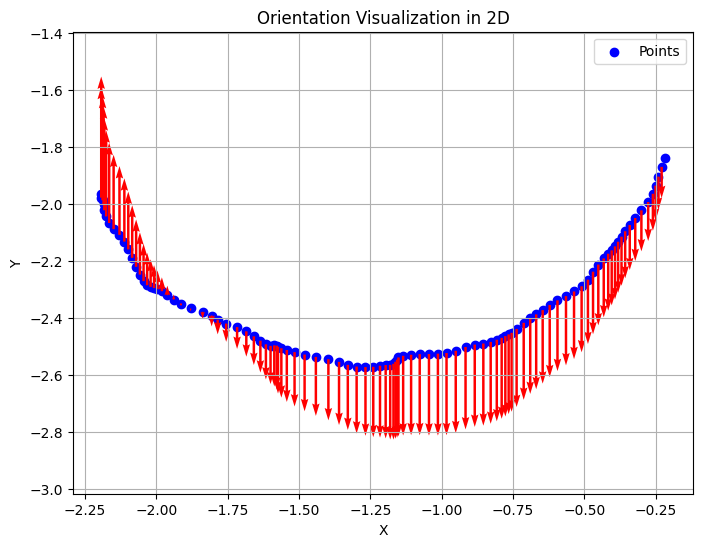

In [24]:
visualize_orientations_2d(rp, r_rot_quat)

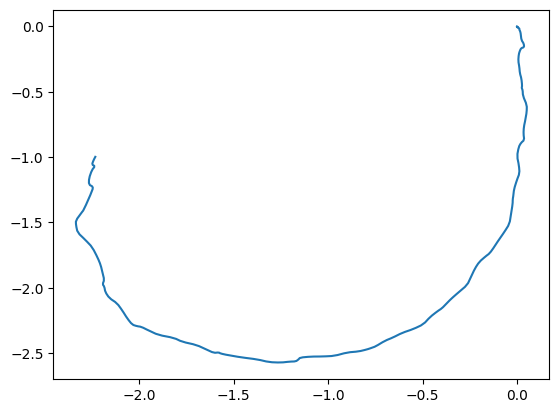

In [36]:
plt.plot(r_pos[:,0] , -r_pos[:,2]) 

In [ ]:
trans = pose[:, 309 : 309 + 3]
root_orient=pose[:, :3]

In [ ]:
root_pos_init = trans[0]
root_pose_init_xz = root_pos_init * np.array([1, 0, 1])
trans = trans - root_pose_init_xz

In [ ]:
plt.plot(trans[:,0] , -trans[:,2])

In [ ]:
plt.plot(r_pos[:,0] , -r_pos[:,2]) 

## Translation transformer

## Streaming transformer

In [ ]:

from core.param_dataclasses import pattern_providers
from core.datasets.multimodal_dataset import MotionIndicesAudioTextDataset, load_dataset_gen, simple_collate
from core.models.utils import instantiate_from_config, get_obj_from_str


In [ ]:
from core import MotionRep, AudioRep, TextRep
from core.datasets.conditioner import ConditionProvider,ConditionFuserStreamer
from core.models.generation.lm import LMModel, MotionGen
import einops

In [ ]:
gen_cfg = strm_get_cfg_defaults()
gen_cfg.merge_from_file("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/motion_streaming/motion_streaming.yaml")
gen_cfg.freeze()

In [ ]:
lm_args = gen_cfg.transformer_lm
target = lm_args.pop("target")
fuse_config = gen_cfg.fuser
pattern_args = gen_cfg.codebooks_pattern
dataset_args = gen_cfg.dataset

In [ ]:
model_gen= MotionGen(lm_args , fuse_config , pattern_args ).to(device)
model_gen = model_gen.eval()

In [ ]:
modeling = pattern_args.pop("modeling")
pattern_provider = pattern_providers[modeling](lm_args.n_q, delays = pattern_args.delays , flatten_first = pattern_args.flatten_first , empty_initial = pattern_args.empty_initial )

In [ ]:
fuse_method = fuse_config.pop("fuse_method")


In [ ]:
fuse_method = {'cross': ['text'], 'input_interpolate': ['audio']}

In [ ]:
if isinstance(fuse_method, list):
    fuse_method = fuse_method[0]
condition_fuser = ConditionFuserStreamer(fuse_method, **fuse_config)

In [ ]:
model = LMModel(
            pattern_provider=pattern_provider,
            fuser=condition_fuser,
            **lm_args
        ).to(device)

In [ ]:
condition_provider = ConditionProvider(
            motion_rep=MotionRep(dataset_args.motion_rep),
            audio_rep=AudioRep(dataset_args.audio_rep),
            text_rep=TextRep(dataset_args.text_rep),
            motion_padding=dataset_args.motion_padding,
            audio_padding=dataset_args.audio_padding,
            motion_max_length_s=10,
            audio_max_length_s=10,
            pad_id = model_gen.model.pad_token_id,
            fps=30/4,
            # device = "cpu"
        )

In [ ]:
from core.datasets.multimodal_dataset import MotionIndicesAudioTextDataset, load_dataset_gen, simple_collate
# dset = MotionIndicesAudioTextDataset("beat" , "/srv/hays-lab/scratch/sanisetty3/motionx" ,motion_rep = "full", split = "render" , fps = 30/4  )


In [ ]:
train_ds, sampler_train, weights_train  = load_dataset_gen(dataset_names = ["humanml"] , dataset_args=dataset_args, split = "test")
train_loader = torch.utils.data.DataLoader(
        train_ds,
        1,
        # sampler=sampler_train,
        # shuffle = False,
        collate_fn=partial(simple_collate , conditioner = condition_provider , permute = True),
        # drop_last=True,
    )

In [ ]:
for inputs, conditions in train_loader:
    break
    

In [ ]:
train_ds.datasets[0].fps

In [ ]:
for inputs, conditions in train_loader:
    input_mask = inputs["motion"][1]
    motions_or_ids = inputs["motion"][0]
    if motions_or_ids.shape[-1] < 1: 
        print(input_mask.shape , motions_or_ids.shape )
    

In [ ]:
inputs["names"]

In [ ]:
input_mask = inputs["motion"][1]
motions_or_ids = inputs["motion"][0].cuda()
B, K, T = motions_or_ids.shape

In [ ]:
motions = inputs["motion"][0].squeeze().to(torch.long)
motion_mask = inputs["motion"][1]


In [ ]:
motions.shape

In [ ]:
conditions["text"][0].shape

In [ ]:
conditions["audio"][0].shape

In [ ]:
conditions["audio"][1]

In [ ]:
cond = conditions["audio"][0]
cond_mask = conditions["audio"][1]
cond = einops.rearrange(cond, "b t d -> b d t")
cond = F.interpolate(cond, size=52)
cond_mask = (
    F.interpolate(
        cond_mask.unsqueeze(1).to(torch.float),
        size=52,
    )
    .squeeze(1)
    .to(torch.bool)
)

In [ ]:
out = model_gen((motions, motion_mask), conditions)

In [ ]:
B , N , C = conditions["audio"][0].shape

In [ ]:
out = model.compute_predictions(inputs["motion"] , conditions)

In [ ]:
audio_embed = model.project_audio(conditions["audio"][0])
text_embed = model.project_text(conditions["text"][0])

In [ ]:
audio_embed.shape

In [ ]:
input_ = sum([model.emb[k](motions_or_ids[:, k]) for k in range(K)])

In [ ]:
motions.shape

## VIusalise motions

In [ ]:
def bkn_to_motion(codes, dset):
        # codes b k n
        body_inds = codes[:, 0]
        left_inds = codes[:, 1]
        right_inds = codes[:, 2]
        body_motion = body_model.decode(body_inds[0:1]).detach().cpu()
        left_motion = left_hand_model.decode(left_inds[0:1]).detach().cpu()
        right_motion = right_hand_model.decode(right_inds[0:1]).detach().cpu()
        body_M = dset.toMotion(
            body_motion[0],
            motion_rep=MotionRep(body_cfg.dataset.motion_rep),
            hml_rep=body_cfg.dataset.hml_rep,
        )
        left_M = dset.toMotion(
            left_motion[0],
            motion_rep=MotionRep(left_cfg.dataset.motion_rep),
            hml_rep=left_cfg.dataset.hml_rep,
        )
        right_M = dset.toMotion(
            right_motion[0],
            motion_rep=MotionRep(right_cfg.dataset.motion_rep),
            hml_rep=right_cfg.dataset.hml_rep,
        )
        full_M = dset.to_full_joint_representation(body_M, left_M, right_M)

        return full_M

In [ ]:
for inputs, conditions in train_loader:
    break
    

In [ ]:
dset = train_ds.datasets[0]

In [ ]:
body_inds = motions_or_ids[:,0]
left_inds = motions_or_ids[:,1]
right_inds = motions_or_ids[:,2]
body_motion = body_model.decode(body_inds[0:1]).detach()
left_motion = left_hand_model.decode(left_inds[0:1]).detach()
right_motion = right_hand_model.decode(right_inds[0:1]).detach()
body_M = dset.toMotion(body_motion[0] , motion_rep = MotionRep(body_cfg.dataset.motion_rep) , hml_rep = body_cfg.dataset.hml_rep , )
left_M = dset.toMotion(left_motion[0] , motion_rep = MotionRep(left_cfg.dataset.motion_rep) , hml_rep = left_cfg.dataset.hml_rep , )
right_M = dset.toMotion(right_motion[0] , motion_rep = MotionRep(right_cfg.dataset.motion_rep) , hml_rep = right_cfg.dataset.hml_rep , )
full_M = dset.to_full_joint_representation(body_M , left_M , right_M )

In [ ]:
motion.device

In [ ]:
motion = inputs["motion"][0]

In [ ]:
gt_motion = bkn_to_motion(motion, dset)

In [ ]:
gt_motion.velocity.shape

In [ ]:
# dset.render_hml(gt_motion , "/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/render/full_joined.gif", from_rotation = True)

In [ ]:
inputs["motion"][0].shape

In [ ]:
body_inds = motions_or_ids[:,0]
body_motion = body_model.decode(body_inds[0:1]).detach()
body_M = dset.toMotion(body_motion[0] , motion_rep = MotionRep(body_cfg.dataset.motion_rep) , hml_rep = body_cfg.dataset.hml_rep , )


In [ ]:
for inputs, conditions in tqdm(train_loader):
    # print(inputs["names"][0])
    
    motion = inputs["motion"][0][...,:300]
    gt_motion = bkn_to_motion(motion, dset)
    # body_inds = motion[:,0]
    # with torch.no_grad():
    #     body_motion = body_model.decode(body_inds[0:1]).cpu()
    # body_M = dset.toMotion(body_motion[0] , motion_rep = MotionRep(body_cfg.dataset.motion_rep) , hml_rep = body_cfg.dataset.hml_rep , )

    dset.render_hml(gt_motion , f"/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/render/all/{os.path.basename(inputs['names'][0])}.gif", from_rotation = True)
    


In [ ]:
body_M.hml_rep

In [ ]:
choreo = np.load("/srv/hays-lab/scratch/sanisetty3/motionx/motion_data/new_joint_vecs/choreomaster/1160.npy")
full_og = dset.toMotion(choreo , motion_rep = MotionRep("full") , hml_rep = "gprvc" )
xyz = dset.to_xyz(full_og, from_rotation=True).cpu()

In [ ]:
import utils.vis_utils.plot_3d_global as plot_3d
plot_3d.render(
            np.array(xyz)[:300],
            "/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/render/full_og.gif",
        )

In [ ]:
choreo.shape

In [ ]:
full_M = dset.inv_transform(full_M)
full_M.tensor()
full_M.root_params = full_og.root_params[:full_M.rotations.shape[0]]
xyz_ = dset.to_xyz(full_M, from_rotation=True).cpu()

In [ ]:
xyz_.shape

In [ ]:

plot_3d.render(
            np.array(xyz_)[:300],
            "/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/render/full_joined.gif",
        )

In [ ]:
null_conditions = model.cfg_dropout(conditions, 1.0)

In [ ]:
out = model.compute_predictions(inputs["motion"] , conditions)

In [ ]:
model = model.eval()

In [ ]:
outt = model.generate(conditions = null_conditions , two_step_cfg =True)

In [ ]:
outt.shape

In [ ]:
import time
start = time.time()
for i in range(10):
    outt = model.generate(conditions = conditions , two_step_cfg =True)
end = time.time()
print('custom attention took {} seconds'.format(end - start))

In [ ]:
import time
start = time.time()
for i in range(10):
    outt = model.generate(conditions = conditions , two_step_cfg =True)
end = time.time()
print('custom attention without flash took {} seconds'.format(end - start))

In [ ]:
import time
start = time.time()
for i in range(10):
    outt = model.generate(conditions = conditions , two_step_cfg =True)
end = time.time()
print('torch attention took {} seconds'.format(end - start))

In [ ]:
model_cfg = cfg_s.transformer_lm

In [ ]:
params = MotionTokenizerParams(model_cfg.card)

In [ ]:
n_q = 3
codes = inputs["motion"][0].permute(0,2,1).to(torch.long)
code_mask = inputs["motion"][1]

In [ ]:
B, K, T = codes.shape
codes = codes.contiguous()

In [ ]:
codes.shape

In [ ]:
pattern = pattern_provider.get_pattern(T)

In [ ]:
pattern

In [ ]:
sequence_codes, sequence_indexes, sequence_mask = (
            pattern.build_pattern_sequence(
                codes,
                1025,
                keep_only_valid_steps=True,
            )
)

In [ ]:
sequence_codes.shape

In [ ]:
code_mask.shape

In [ ]:
sequence_mask.shape

In [ ]:
new_mask = torch.ones_like(sequence_mask).repeat(B , 1 , 1)
for i in range(n_q):
    new_mask[:,i,i+1:] = code_mask[:,0:T-i]

In [ ]:
new_mask.shape

In [ ]:
new_new_mask = (new_mask.sum(1) == new_mask.shape[1])

In [ ]:
new_new_mask[0]

In [ ]:
from core.datasets.audio_encoders import EncodecConditioner

In [ ]:
audio_list = findAllFile("/srv/hays-lab/scratch/sanisetty3/motionx/audio/wav/")

In [ ]:
audenc = EncodecConditioner(target_sr = 9600)
# audlib = AudioConditionerLibrosa()

In [ ]:
for src in tqdm(audio_list):
    embs = audenc(audio_list[0])
    np.save(src.replace("/wav" , "/encodec").replace(".wav" , ".npy") , embs.detach().cpu().numpy())

In [ ]:
audio_list[0]

In [ ]:
emb = audenc(audio_list[0])

In [ ]:
emb.shape

In [ ]:
np.load("/srv/hays-lab/scratch/sanisetty3/motionx/audio/encodec/aist/mBR0.npy").shape

In [ ]:
emb = audenc("/srv/hays-lab/scratch/sanisetty3/motionx/audio/wav/choreomaster/0071.wav")

In [ ]:
emb2 = audlib("/srv/hays-lab/scratch/sanisetty3/motionx/audio/wav/choreomaster/0071.wav")

In [ ]:
emb2.shape

In [ ]:
emb.shape

In [ ]:
emb1 = np.load("/srv/hays-lab/scratch/sanisetty3/motionx/audio/encodec/choreomaster/0071.npy")

In [ ]:
emb1.shape